# 1. Introdução <a name="1"></a>

Este trabalho constitui desafio vivencial da trilha de formação de cientista de dados na [PETROBRAS](https://petrobras.com.br).
Foi escolhida a competição de [Santander Customer Transaction Prediction](https://www.kaggle.com/c/santander-customer-transaction-prediction/overview). Essa é uma competição encerrada em Abril de 2019 que ofereceu US$ 65.000 do 1° ao 5° lugares. Nessa competição, o objetivo é prever quais clientes irão realizar uma transação específica no futuro, independente do valor.

In [ ]:
%time
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # gráficos

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
train_df= pd.read_csv("../input/santander-customer-transaction-prediction/train.csv")
test_df = pd.read_csv('../input/santander-customer-transaction-prediction/test.csv')
sample_submission = pd.read_csv('../input/santander-customer-transaction-prediction/sample_submission.csv')
sample_submission.head()

# 2. Análise exploratória de dados - EDA <a name="2"></a>


Referências utilizadas:

[Santander EDA and Prediction](https://www.kaggle.com/gpreda/santander-eda-and-prediction)

[Pandas documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html)

Na descrição dos dados. é informado que os valores disponibilizados para previsão são numéricos e anonimizados, (conforme observado em [Santander Customer Transaction - EDA](https://www.kaggle.com/allunia/santander-customer-transaction-eda)) e tem estrutura similar à disponível para a solução do probelma, o que sugere que os dados são sintéticos.
Por se tratar de informação de transações financeiras, é compreensível que os dados sejam anonimizados, porém o fato de não saber o que cada uma das muitas colunas significa, dificulta a análise de dados e possíveis idéias de combinação de variáveis para melhorar o resultado do modelo.

In [ ]:
train_df.describe()

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribuição dos valores médios por coluna nos conjuntos de treino e de teste")
sns.distplot(train_df[features].mean(axis=1),color="green", kde=True,bins=120, label='train')
sns.distplot(test_df[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

É possível observar que as médias e desvios padrão estão distribuídos em uma grande variedade de valores, o que leva a entender que esses dados não estão padronizados. Caso estivessem padronizados, a média seria, zero e o desvio padrão seria unitário. Isso pode ser um problema para modelos baseados em redes neurais(vide [Why Data should be Normalized before Training a Neural Network](https://towardsdatascience.com/why-data-should-be-normalized-before-training-a-neural-network-c626b7f66c7d)), porém é indiferente para modelos baseados em árvores de decisão(vide [Scaling/Normalization not need for tree based models](https://stats.stackexchange.com/questions/262895/scaling-normalization-not-need-for-tree-based-models)), como o que será utilizado.

In [ ]:
train_df.info(verbose = True, show_counts = True)

A partir da função info(), é possível observar que os dados de treino são compostos de um campo de texto "ID_code", um campo inteiro "target" (que pode assumir os valores de 0 ou 1) e todos os demais campos são do tipo número real. A partir dessa mesma função é possível observar que não existem valores faltantes (NaN).

In [ ]:
sns.countplot(x = train_df.target.values)

A partir da contagem da variável "target" é possível observar que existe um desequilíbrio de classes uma vez que existem muito mais transações não realizadas que transações realizadas.

In [ ]:
import matplotlib.pyplot as plt
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,44))

    for feature in features:
        i += 1
        plt.subplot(20,10,i)
        sns.kdeplot(df1[feature],
                    label=label1)
        sns.kdeplot(df2[feature],
                     label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
features = train_df.columns.values[2:202]
plot_feature_distribution(t0, t1, '0', '1', features)

É possível observar que as variáveis apresentam, via de regra, [distribuição semelhante a uma normal](https://pt.wikipedia.org/wiki/Distribui%C3%A7%C3%A3o_normal) de dados.
É possível observar um relevante número de variáveis que apresentam distribuições diferentes entre as transações realizadas (saída 1 corresponde às linhas cor de laranja) e as transações não realizadas (saida 0 corresponde a linhas azuis). Esse comportamento pode ser observado nas variáveis var_0, var_1, var_2, var_5, var_9, var_13, var_106, var_139 e muitas outras.

Algumas variáveis apresentam distribuições de frequência que se assemelham a [distribuição bimodal](https://pt.wikipedia.org/wiki/Distribui%C3%A7%C3%A3o_bimodal) como var_2, var_13, var_26, var_55, var_175, var_184, var_196.

In [ ]:
from tqdm import tqdm
from scipy import stats
FEATURES = [column for column in train_df.columns if 'var' in column]
alpha = 1e-3
all_normal = True
for feature in tqdm(FEATURES):
    if stats.normaltest(train_df[feature].values).pvalue > alpha:
        all_normal = False
        print(f'{feature} may not be normal')
if all_normal:
    print('All features are normally distributed')

https://www.kaggle.com/code/levorato/tp3-vivencial-cd-petro

In [ ]:
# Correlation matrix
cor = train_df.drop(["ID_code"], axis = 1).corr()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# Plotting heatmap
plt.figure(figsize=(50,30))
sns.heatmap(cor, vmin = -1, vmax = +1, cmap = 'coolwarm')  # annot = True,

In [ ]:
features = train_df.columns.values[2:202]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)

À primeira vista, as distribuições dos dados de treino e teste parecem idênticas. Uma avaliação minuciosa demonstra pequenas diferenças, especialmente próximo às modas, onde pequenas seções dos dados de treino (linha azul) ficam visíveis sob a distribuição dos dados de teste (linha laranja).
A existência de diferenças de distribuições entre os dados com saída 0 e saída 1 são um bom sinal pois demonstram que existem, nos dados, informações que podem permitir a predição da variável objetivo (*target*).
A existência de uma grande semelhança entre os dados de treino e teste também é um bom sinal, pois evidencia que o treino é representativo do teste. Em caso contrário, o modelo poderia sofrer *overfitting* nos dados de treino e ter baixo desempenho nos dados de teste.
Mais do que felizes coincidências, as observações realizadas indicam (conforme observado no notebook [Santander Customer Transaction - EDA](https://www.kaggle.com/allunia/santander-customer-transaction-eda)) que os dados da competição são simulados, ou seja, foram gerados especificamente para a competição com métricas similares aos dados reais porém sem consistir em dados reais anonimizados.

In [ ]:
X = train_df.copy()
y = X.pop("target")
X.pop("ID_code")
discrete_features = X.dtypes == int
X.head()

Segue visualização bidimensional dos gráficos obtida com a redução de dimensionalidade obtida pelo métido PCA.
https://plotly.com/python/pca-visualization/

In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(X)

fig = px.scatter(components,
                 x = 0,
                 y = 1,
                 color = y.astype("string")
                )
fig.show()

Segue visualização bidimensional dos gráficos obtida com a redução de dimensionalidade obtida pelo métido TSNE.
https://plotly.com/python/t-sne-and-umap-projections/

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

features = X

tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(features)

fig = px.scatter(
    projections, x = 0, y = 1,
    color = y.astype("string"),
)
fig.show()

# 3. Estratégia de validação <a name="3"></a>
Foi realizada a divisão de 30% dos dados para teste.
Na fase de busca de hiperparâmetros foi utilizada validação cruzada com 5 folds.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# 4. Ajuste de hiperparâmetros

Ajuste simplificado de hiperparâmetros realizado utilizando como referência a postagem no StackOverflow [Grid search with LightGBM example](https://stackoverflow.com/questions/50686645/grid-search-with-lightgbm-example).

In [ ]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

np.random.seed(1)

gkf = KFold(n_splits=5, shuffle=True, random_state=42).split(X=X, y=y)

param_grid = {
    "max_depth" : [15, 20, 25, 30, 35],
    "num_leaves": [31, 59, 127],
    "learning_rate": [0.1, 0.05, 0.01],
    }

lgb_estimator = lgb.LGBMClassifier(
                        objective = "binary",
                        is_unbalance = True,
                        )

gsearch = GridSearchCV(estimator = lgb_estimator,
                       param_grid = param_grid,
                       cv = gkf,
                       scoring = "roc_auc",
                      )
lgb_model = gsearch.fit(X=X, y=y)

print(lgb_model.best_params_, lgb_model.best_score_)

# 5. Treino do modelo <a name="4"></a>


O treino do modelo foi realizado com código obtido do notebook [LightGBM Classifier in Python ](https://www.kaggle.com/code/prashant111/lightgbm-classifier-in-python/notebook). Assim como a maioria das submissões com melhor classificação no ranking da competição, nesse código é utilizado um modelo do tipo [LightGBM](https://www.kaggle.com/prashant111/lightgbm-classifier-in-python). O LightGBM é um ensemble de árvores de decisão, similar ao random forest. Ele usa gradient boost de forma similar ao Xgboost tendo sido desenvolvido pela Microsoft (vide [GitHub](https://github.com/microsoft/LightGBM)).

In [ ]:
# build the lightgbm model
import lightgbm as lgb
clf = lgb.LGBMClassifier(
                        objective = "binary",
                        is_unbalance = True,
                        learning_rate = 0.1,
                        num_leaves = 59,
                        max_depth = 15,
                        )
clf.fit(X_train, y_train)

In [ ]:
# predict the results
y_pred=clf.predict(X_test)

In [ ]:
# view accuracy
from sklearn.metrics import roc_auc_score
accuracy=roc_auc_score(y_pred, y_test)
print('LightGBM Model ROC AUC score: {0:0.4f}'.format(roc_auc_score(y_test, y_pred)))

In [ ]:
# view confusion-matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=["Predict Negative:0", "Predict Positive:1"], 
                                 index=["Actual Negative:0", "Actual Positive:1"])
sns.heatmap(cm_matrix, annot=True, fmt="d", cmap="YlGnBu")

In [ ]:
y_test.value_counts()

É possível observar um grande número de falsos positivos.
Devido ao fato de a métrica da competição ser a ROC AUC, serão utilizadas as probabilidades de predição.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
test_df.head()

In [ ]:
X_envio = test_df.copy()
X_envio.pop("ID_code")
#unseen_predictions = clf.predict(X_envio)
unseen_predictions = clf.predict_proba(X_envio,
#                                      raw_score = True,
                                      )

In [ ]:
df_unseen_predictions = pd.DataFrame(unseen_predictions)
df_unseen_predictions.head()

# 6. Submissão <a name="5"></a>
O resultado do modelo é salvo em um arquivo .CSV entitulado "submission".

In [ ]:
## %time
#pd.DataFrame({"ID_code":test_df["ID_code"], "target":df_unseen_predictions[0]}).to_csv("submission.csv", index=False)
y_envio = pd.DataFrame({"ID_code":test_df["ID_code"], "target":df_unseen_predictions[1]})
y_envio.to_csv("submission.csv", index=False)

Esse resultado obteve a seguinte nota na competição:0,86645

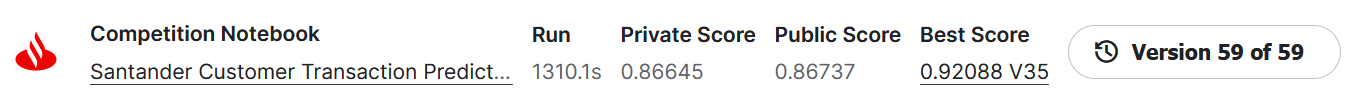

# 7. Análise de resultados

In [ ]:
y_envio.head()

In [ ]:
y_envio.describe()

Para visualizar a distribuição das classes nos dados de teste, foi gerado um gráfico similar ao gerado anteriormente para os dados de treino. O resultado foi desequilibrado, com distribuição similar ao primeiro gráfico.

In [ ]:
y_envio_discreto =  np.where(df_unseen_predictions[1] > 0.5, 1, 0)
sns.countplot(x = y_envio_discreto)

De forma similar, é feito um gráfico com a distribuição das classes preditas nos dados de validação. É possível observar uma distribuição menos desbalanceada que as anteriores, mostrando um viés no algoritmo.

In [ ]:
df_unseen_predictions.describe()

In [ ]:
sns.countplot(x = y_pred)

In [ ]:
y_pred_proba=clf.predict_proba(X_test,
#                              raw_score=True,
                              )
y_pred_proba

df_y_pred_proba = pd.DataFrame(y_pred_proba)
df_y_pred_proba[1]

In [ ]:
len(y_test)

In [ ]:
df_y_envio = pd.DataFrame({"Actual":y_test, "Predicted":df_y_pred_proba[1].to_numpy()})
df_y_envio

O código a seguir tem o objetivo de mostrar os piores erros falsos positivos.

In [ ]:
df_y_envio.loc[df_y_envio["Actual"]==0].sort_values("Predicted", ascending = False).head()

O código a seguir tem o objetivo de mostrar os piores erros falsos negativos.

In [ ]:
df_y_envio.loc[df_y_envio["Actual"] == 1].sort_values("Predicted", ascending = True).head()